In [1]:
import logging
import os.path
import time
from collections import OrderedDict
import sys

import numpy as np
import torch.nn.functional as F
from torch import optim

from braindecode.models.deep4 import Deep4Net
from braindecode.datasets.bcic_iv_2a import BCICompetition4Set2A
from braindecode.experiments.experiment import Experiment
from braindecode.experiments.monitors import LossMonitor, MisclassMonitor, \
    RuntimeMonitor
from braindecode.experiments.stopcriteria import MaxEpochs, NoDecrease, Or
from braindecode.datautil.iterators import BalancedBatchSizeIterator
from braindecode.models.shallow_fbcsp import ShallowFBCSPNet
from braindecode.datautil.splitters import split_into_two_sets
from braindecode.torch_ext.constraints import MaxNormDefaultConstraint
from braindecode.torch_ext.util import set_random_seeds, np_to_var
from braindecode.mne_ext.signalproc import mne_apply
from braindecode.datautil.signalproc import (bandpass_cnt,
                                             exponential_running_standardize)
from braindecode.datautil.trial_segment import create_signal_target_from_raw_mne

log = logging.getLogger(__name__)

<p>Here's the description from the paper</p>
<img src="DeepConvNet.png" style="width: 700px; float:left;">

<p>Here's the description from the paper</p>
<img src="DeepConvNetDetail.png" style="width: 700px; float:left;">

In [17]:
def run_exp(data_folder, subject_id, low_cut_hz, model, cuda):
    ival = [-500, 4000]
    max_epochs = 1600
    max_increase_epochs = 160
    batch_size = 60
    high_cut_hz = 38
    factor_new = 1e-3
    init_block_size = 1000
    valid_set_fraction = 0.2

    train_filename = 'A{:02d}T.gdf'.format(subject_id)
    test_filename = 'A{:02d}E.gdf'.format(subject_id)
    train_filepath = os.path.join(data_folder, train_filename)
    test_filepath = os.path.join(data_folder, test_filename)
    train_label_filepath = train_filepath.replace('.gdf', '.mat')
    test_label_filepath = test_filepath.replace('.gdf', '.mat')

    train_loader = BCICompetition4Set2A(
        train_filepath, labels_filename=train_label_filepath)
    test_loader = BCICompetition4Set2A(
        test_filepath, labels_filename=test_label_filepath)
    train_cnt = train_loader.load()
    test_cnt = test_loader.load()

    # Preprocessing

    train_cnt = train_cnt.drop_channels(['STI 014', 'EOG-left',
                                         'EOG-central', 'EOG-right'])
    assert len(train_cnt.ch_names) == 22
    # lets convert to millvolt for numerical stability of next operations
    train_cnt = mne_apply(lambda a: a * 1e6, train_cnt)
    train_cnt = mne_apply(
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, train_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), train_cnt)
    train_cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        train_cnt)

    test_cnt = test_cnt.drop_channels(['STI 014', 'EOG-left',
                                       'EOG-central', 'EOG-right'])
    assert len(test_cnt.ch_names) == 22
    test_cnt = mne_apply(lambda a: a * 1e6, test_cnt)
    test_cnt = mne_apply(
        lambda a: bandpass_cnt(a, low_cut_hz, high_cut_hz, test_cnt.info['sfreq'],
                               filt_order=3,
                               axis=1), test_cnt)
    test_cnt = mne_apply(
        lambda a: exponential_running_standardize(a.T, factor_new=factor_new,
                                                  init_block_size=init_block_size,
                                                  eps=1e-4).T,
        test_cnt)

    marker_def = OrderedDict([('Left Hand', [1]), ('Right Hand', [2],),
                              ('Foot', [3]), ('Tongue', [4])])

    train_set = create_signal_target_from_raw_mne(train_cnt, marker_def, ival)
    test_set = create_signal_target_from_raw_mne(test_cnt, marker_def, ival)

    train_set, valid_set = split_into_two_sets(
        train_set, first_set_fraction=1-valid_set_fraction)

    set_random_seeds(seed=20190706, cuda=cuda)

    n_classes = 4
    n_chans = int(train_set.X.shape[1])
    input_time_length = train_set.X.shape[2]
    if model == 'shallow':
        model = ShallowFBCSPNet(n_chans, n_classes, input_time_length=input_time_length,
                            final_conv_length='auto').create_network()
    elif model == 'deep':
        model = Deep4Net(n_chans, n_classes, input_time_length=input_time_length,
                            final_conv_length='auto').create_network()
    if cuda:
        model.cuda()
    log.info("Model: \n{:s}".format(str(model)))

    optimizer = optim.Adam(model.parameters())

    iterator = BalancedBatchSizeIterator(batch_size=batch_size)

    stop_criterion = Or([MaxEpochs(max_epochs),
                         NoDecrease('valid_misclass', max_increase_epochs)])

    monitors = [LossMonitor(), MisclassMonitor(), RuntimeMonitor()]

    model_constraint = MaxNormDefaultConstraint()

    exp = Experiment(model, train_set, valid_set, test_set, iterator=iterator,
                     loss_function=F.nll_loss, optimizer=optimizer,
                     model_constraint=model_constraint,
                     monitors=monitors,
                     stop_criterion=stop_criterion,
                     remember_best_column='valid_misclass',
                     run_after_early_stop=True, cuda=cuda)
    exp.run()
    return exp

In [19]:
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s',
                    level=logging.DEBUG, stream=sys.stdout)
# Should contain both .gdf files and .mat-labelfiles from competition
data_folder = './data/BCICIV_2a_gdf/'
subject_id = 1 # 1-9
low_cut_hz = 4 # 0 or 4
model = 'deep' #'shallow' or 'deep'
cuda = False
exp = run_exp(data_folder, subject_id, low_cut_hz, model, cuda)
log.info("Last 10 epochs")
log.info("\n" + str(exp.epochs_df.iloc[-10:]))

Extracting EDF parameters from ./data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/anaconda3/lib/python3.6/site-packages/mne/io/edf/edf.py:1083: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
/anaconda3/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/anaconda3/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/anaconda3/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


Extracting EDF parameters from ./data/BCICIV_2a_gdf/A01E.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 686999  =      0.000 ...  2747.996 secs...


/anaconda3/lib/python3.6/site-packages/mne/io/edf/edf.py:1083: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
/anaconda3/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/anaconda3/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')
/anaconda3/lib/python3.6/site-packages/braindecode/datasets/bcic_iv_2a.py:20: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(self.filename, stim_channel='auto')


2019-02-12 20:51:21,288 INFO : Trial per class:
Counter({'Tongue': 72, 'Foot': 72, 'Right Hand': 72, 'Left Hand': 72})
2019-02-12 20:51:21,598 INFO : Trial per class:
Counter({'Left Hand': 72, 'Right Hand': 72, 'Foot': 72, 'Tongue': 72})
2019-02-12 20:51:21,895 INFO : Model: 
Sequential(
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 25, kernel_size=(10, 1), stride=(1, 1))
  (conv_spat): Conv2d(25, 25, kernel_size=(1, 22), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(25, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=elu)
  (pool): MaxPool2d(kernel_size=(3, 1), stride=(3, 1), padding=0, dilation=1, ceil_mode=False)
  (pool_nonlin): Expression(expression=identity)
  (drop_2): Dropout(p=0.5)
  (conv_2): Conv2d(25, 50, kernel_size=(10, 1), stride=(1, 1), bias=False)
  (bnorm_2): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nonlin_2): Expression(expres

KeyboardInterrupt: 

In [4]:
data_folder = './data/BCICIV_2a_gdf/'
train_filename = 'A{:02d}T.gdf'.format(subject_id)
test_filename = 'A{:02d}E.gdf'.format(subject_id)
train_filepath = os.path.join(data_folder, train_filename)
test_filepath = os.path.join(data_folder, test_filename)
train_label_filepath = train_filepath.replace('.gdf', '.mat')
test_label_filepath = test_filepath.replace('.gdf', '.mat')
train_loader = BCICompetition4Set2A(
        train_filepath, labels_filename=train_label_filepath)

# cnt = self.extract_data()
# events, artifact_trial_mask = self.extract_events(cnt)
# cnt.info['events'] = events
# cnt.info['artifact_trial_mask'] = artifact_trial_mask



In [5]:
Stop
import mne
raw_edf = mne.io.read_raw_edf(train_filepath, stim_channel='auto')
raw_edf.load_data()
data = raw_edf.get_data()

Extracting EDF parameters from ./data/BCICIV_2a_gdf/A01T.gdf...
GDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


/anaconda3/lib/python3.6/site-packages/mne/io/edf/edf.py:1083: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  etmode = np.fromstring(etmode, np.uint8).tolist()[0]
<ipython-input-5-a1842a4aa3d7>:2: RuntimeWarning: Overlapping events detected. Use find_edf_events for the original events.
  raw_edf = mne.io.read_raw_edf(train_filepath, stim_channel='auto')
<ipython-input-5-a1842a4aa3d7>:2: RuntimeWarning: Interpolating stim channel. Events may jitter.
  raw_edf = mne.io.read_raw_edf(train_filepath, stim_channel='auto')
<ipython-input-5-a1842a4aa3d7>:2: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  raw_edf = mne.io.read_raw_edf(train_filepath, stim_channel='auto')


In [6]:
raw_edf.info

<Info | 16 non-empty fields
    bads : list | 0 items
    ch_names : list | EEG-Fz, EEG-0, EEG-1, EEG-2, EEG-3, EEG-4, EEG-5, ...
    chs : list | 26 items (EEG: 25, STIM: 1)
    comps : list | 0 items
    custom_ref_applied : bool | False
    dev_head_t : Transform | 3 items
    events : list | 0 items
    highpass : float | 0.5 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 0 items
    lowpass : float | 100.0 Hz
    meas_date : tuple | 2005-01-17 12:00:00 GMT
    nchan : int | 26
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 250.0 Hz
    acq_pars : NoneType
    acq_stim : NoneType
    ctf_head_t : NoneType
    description : NoneType
    dev_ctf_t : NoneType
    dig : NoneType
    experimenter : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    kit_system_id : NoneType
    line_freq : NoneType
    meas_id : NoneType
    proj_id : NoneType
    proj_name : NoneType
    subject_info : NoneType
    xp

2019-02-12 20:34:12,528 DEBUG : update_title_pos
2019-02-12 20:34:12,565 DEBUG : update_title_pos
2019-02-12 20:34:12,596 DEBUG : update_title_pos
2019-02-12 20:34:12,629 DEBUG : update_title_pos
2019-02-12 20:34:12,647 DEBUG : update_title_pos


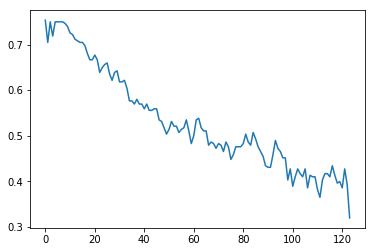

In [15]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(exp.epochs_df['test_misclass'])


In [14]:
exp.epochs_df

train_loss  valid_loss  test_loss  train_misclass  valid_misclass  \
0      1.441879    1.405375   1.429315        0.747826        0.775862   
1      1.368649    1.380442   1.369595        0.717391        0.775862   
2      1.530694    1.588478   1.535021        0.743478        0.775862   
3      1.896133    2.025539   1.907914        0.682609        0.793103   
4      2.532888    2.743549   2.551060        0.743478        0.775862   
5      2.979870    3.259540   2.998601        0.743478        0.775862   
6      3.104247    3.489383   3.141852        0.743478        0.775862   
7      3.068217    3.534096   3.105667        0.743478        0.775862   
8      3.002282    3.537081   3.039664        0.739130        0.775862   
9      2.806259    3.397973   2.863057        0.721739        0.775862   
10     2.684402    3.277142   2.739682        0.713043        0.775862   
11     2.680008    3.294525   2.761077        0.713043        0.775862   
12     2.433926    3.060590   2.580139        0.700000        0.775862   
13     2.356114    2.979027   2.527742        0.691304        0.775862   
14     2.344212    2.950974   2.521890        0.686957        0.775862   
15     2.311657    2.918518   2.501140        0.678261        0.775862   
16     2.188965    2.773315   2.379953        0.669565        0.758621   
17     2.074629    2.641801   2.263226        0.652174        0.741379   
18     1.892167    2.474407   2.106016        0.630435        0.724138   
19     1.936568    2.562576   2.157722        0.656522        0.741379   
20     2.065490    2.775990   2.299773        0.647826        0.741379   
21     1.922781    2.644304   2.184341        0.626087        0.724138   
22     1.648363    2.332223   1.942371        0.591304        0.706897   
23     1.886910    2.592978   2.156252        0.630435        0.758621   
24     1.894080    2.628870   2.156801        0.639130        0.741379   
25     1.869447    2.628780   2.136935        0.630435        0.741379   
26     1.847853    2.591529   2.125970        0.621739        0.741379   
27     1.717492    2.455853   2.017844        0.595652        0.741379   
28     1.801834    2.580056   2.111988        0.600000        0.741379   
29     1.830338    2.643034   2.144135        0.604348        0.724138   
..          ...         ...        ...             ...             ...   
94     0.720066    1.497772   1.401841        0.284722        0.465517   
95     0.678984    1.374029   1.329564        0.246528        0.431034   
96     0.586512    1.298434   1.237851        0.225694        0.413793   
97     0.651747    1.250453   1.289527        0.270833        0.465517   
98     0.517346    0.969094   1.093727        0.208333        0.310345   
99     0.539854    0.997077   1.168367        0.218750        0.396552   
100    0.435593    0.881821   1.042820        0.173611        0.344828   
101    0.441343    0.837679   1.070325        0.194444        0.310345   
102    0.587771    0.982054   1.250240        0.218750        0.344828   
103    0.512586    0.950595   1.158567        0.218750        0.396552   
104    0.360291    0.780645   1.038696        0.156250        0.344828   
105    0.351780    0.724145   1.057757        0.149306        0.344828   
106    0.348796    0.643827   1.019051        0.159722        0.275862   
107    0.404671    0.730122   1.083637        0.166667        0.293103   
108    0.377772    0.733600   1.097592        0.166667        0.344828   
109    0.332467    0.642787   1.066131        0.159722        0.327586   
110    0.306816    0.539793   1.024242        0.131944        0.258621   
111    0.239402    0.442503   0.939801        0.111111        0.241379   
112    0.236304    0.472072   0.977309        0.100694        0.241379   
113    0.303801    0.553191   1.087420        0.135417        0.275862   
114    0.287558    0.493353   1.013832        0.121528        0.224138   
115    0.372596    0.613294   1.155101        0.159722        0.258621   
116    0.